## Load Samples

In [4]:
import pandas as pd

bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()
uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
# existing_proteins_list
proteins_df = bio_df[existing_proteins_list[0:30]]
# print(existing_proteins_list)

## Functional Enrichment Analysis Without Clustering

C:\Users\pshad\AppData\Local\Temp\ipykernel_2668\247669080.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['source'].map(color_mapping)


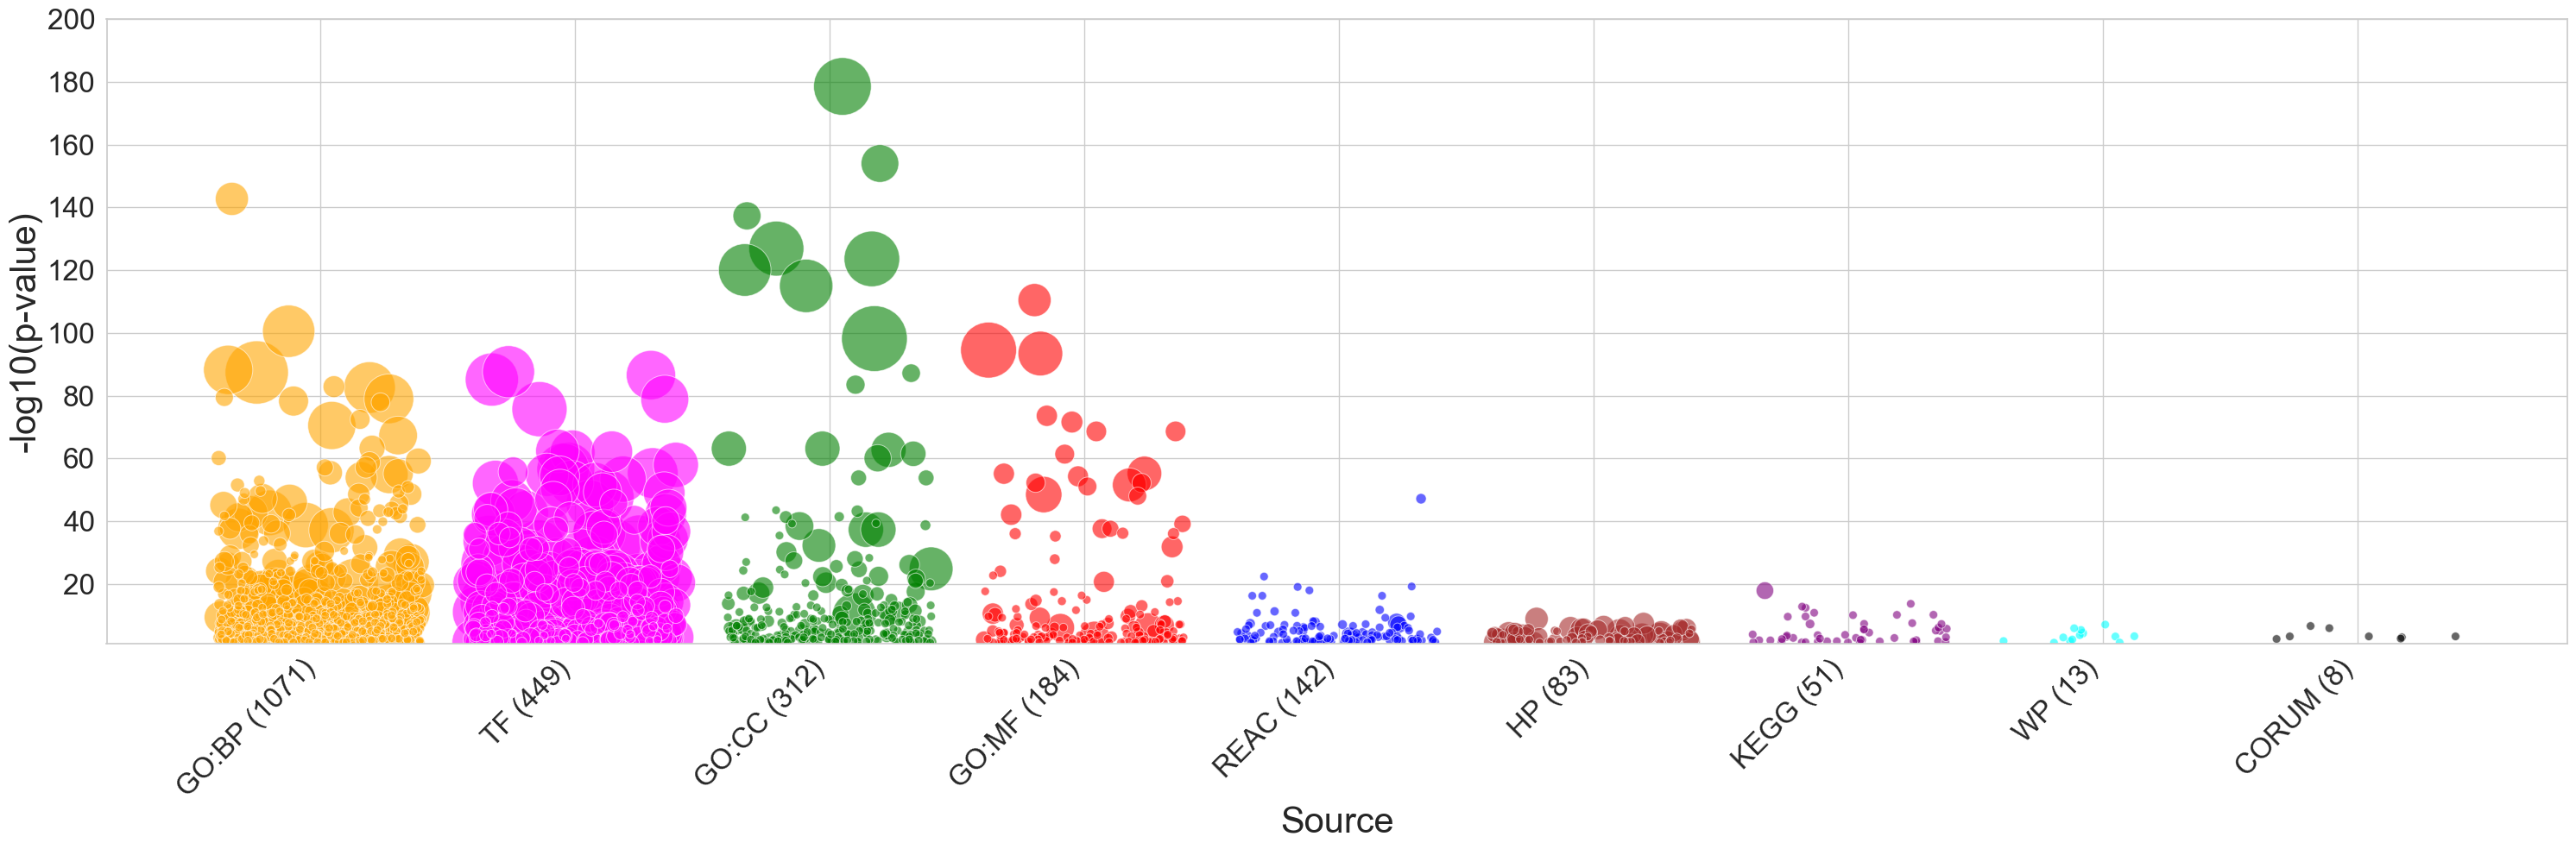

In [6]:
import gprofiler as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Initialize g:Profiler client
gp_client = gp.GProfiler(return_dataframe=True)

# Perform g:Profiler analysis
results = gp_client.profile(organism='mmusculus', query=existing_proteins_list)

# Save results to a CSV file if you want to inspect or reuse them
results.to_csv('gprofiler_results.csv', index=False)

# Load the results
results = pd.read_csv('gprofiler_results.csv')

# Calculate the negative log10 of the p-values
results['-log10(p_value)'] = -np.log10(results['p_value'])

# Extract the necessary columns
data = results[['source', 'name', '-log10(p_value)', 'term_size']]

# Assign colors based on 'source'
color_mapping = {
    'GO:CC': 'green', 'GO:BP': 'orange', 'GO:MF': 'red', 'TF': 'magenta',
    'REAC': 'blue', 'KEGG': 'purple', 'HP': 'brown', 'WP': 'cyan', 'CORUM': 'black'
}
data['color'] = data['source'].map(color_mapping)

# Sort the data within each category based on term_size
data = data.sort_values(by=['source', 'term_size'], ascending=[True, False]).reset_index(drop=True)

# Count the number of terms in each category and sort categories by these counts
category_counts = data['source'].value_counts()
sorted_categories = category_counts.index

# Create numeric categories for x-axis with increased spacing based on sorted order
category_map = {category: i * 100 for i, category in enumerate(sorted_categories)}
data['category_num'] = data['source'].map(category_map)

# Add jitter to the x-axis within each category for better dispersion
data['jitter'] = data.groupby('source').cumcount().apply(lambda x: np.random.uniform(-40, 40))

# Adjust x-coordinate with jitter
data['adjusted_x'] = data['category_num'] + data['jitter']

# Scale the term_size for better visualization
size_scaling_factor = 3000 / data['term_size'].max()  # Adjusted scaling factor for better visibility
data['scaled_size'] = data['term_size'] * size_scaling_factor

# Apply a minimum size threshold
min_size = 50
data['scaled_size'] = data['scaled_size'].apply(lambda x: max(x, min_size))

# Set the style
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(30, 10))

# Draw the points with adjusted x-coordinates and scaled sizes
plt.scatter(
    x=data['adjusted_x'],
    y=data['-log10(p_value)'],
    s=data['scaled_size'],
    c=data['color'],
    alpha=0.6,
    edgecolors='w',
    linewidth=0.7
)

# Improve the plot aesthetics
plt.xticks([category_map[cat] for cat in sorted_categories], [f'{cat} ({category_counts[cat]})' for cat in sorted_categories], rotation=45, ha='right', fontsize=24)
plt.xlabel('Source', fontsize=30)
plt.ylabel('-log10(p-value)', fontsize=30)
plt.yticks(np.arange(0, 250, 20), fontsize=24)  # Set y-axis ticks to be in increments of 20
plt.ylim(1, 200)  # Adjust the y-axis limit if needed
# plt.title('g:Profiler Results', fontsize=36)

# Add legends
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=key) 
    for key, color in color_mapping.items()
]
# Custom legend for bubble sizes
# sizes = [100, 500, 1000, 2000]
# for size in sizes:
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(size * size_scaling_factor), label=f'Term Size {size}'))

# plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)

# Show the plot
plt.tight_layout()
plt.savefig('gprofiler_scatter_plot_updated_with_sizes.png', dpi=300)
plt.show()


## Evaluation

In [8]:
from utils_functions import *
from train import GAEPipeline
from train import GCNEncoder
model_dir = 'models'  # Directory where model files are saved
graph_path = 'data/combined_graph_latest.pkl'
n_clusters = 3 

pipeline = GAEPipeline(in_channels=15, out_channels=32, sampling_method='clusterGCN', hidden_channels = 20, num_layers = 1, dropout_rate=0.05)
graph = pipeline.load_graph_from_pickle(graph_path)

data = pipeline.preprocess_graph(graph)
models = generate_embeddings_from_models(model_dir, data, pipeline)
protein_indices_in_pyg = get_protein_indices_in_pyg(graph, existing_proteins_list)
kmeans = KMeans(n_init=10, n_clusters=n_clusters, random_state=2)
metrics, emd_metrics,  frobenius_norm_metrics = evaluate_embeddings(models, n_clusters,protein_indices_in_pyg, pipeline, kmeans, graph_path)



Feature matrix shape: torch.Size([50164, 15])


C:\Users\pshad\anaconda3\envs\gnnenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pshad\anaconda3\envs\gnnenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\pshad\anaconda3\envs\gnnenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pshad\anaconda3\envs\gnnenv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a

Top 10 novel associations in Cluster 0:
                               name source       p_value  term_size
18                ribosomal subunit  GO:CC  1.561588e-46        202
39             spliceosomal complex  GO:CC  4.084108e-37        219
57                         ribosome  GO:CC  1.373314e-31        420
59              organellar ribosome  GO:CC  2.101788e-30         90
60           mitochondrial ribosome  GO:CC  2.101788e-30         90
70         Neutrophil degranulation   REAC  3.904831e-28        511
71     U2-type spliceosomal complex  GO:CC  4.612099e-28        109
73    mRNA Splicing - Major Pathway   REAC  1.438060e-27        185
79                    mRNA Splicing   REAC  1.755689e-26        191
80  macromolecule metabolic process  GO:BP  7.255710e-26      12286
Top 10 novel associations in Cluster 1:
                                               name source       p_value  \
1566           carboxylic acid biosynthetic process  GO:BP  4.633785e-16   
1568              or

D:\gnn-pathways\utils_functions.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['-log10(p_value)'] = -np.log10(cluster_data['p_value'])
D:\gnn-pathways\utils_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['source'].map(color_mapping)
D:\gnn-pathways\utils_functions.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Top 10 novel associations in Cluster 0:
                                        name source       p_value  term_size
19  mitochondrial protein-containing complex  GO:CC  1.032050e-47        298
23                         ribosomal subunit  GO:CC  8.127768e-45        202
26                      spliceosomal complex  GO:CC  2.606609e-42        219
50              U2-type spliceosomal complex  GO:CC  7.921109e-35        109
60             mRNA Splicing - Major Pathway   REAC  1.000752e-31        185
63                             mRNA Splicing   REAC  1.727572e-30        191
65                                  ribosome  GO:CC  7.638335e-30        420
66              catalytic step 2 spliceosome  GO:CC  9.032447e-30        108
68                       organellar ribosome  GO:CC  2.013117e-29         90
69                    mitochondrial ribosome  GO:CC  2.013117e-29         90
Top 10 novel associations in Cluster 1:
                                               name source       p_value 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
